In [1]:
import sys
sys.path.append('C:/ProgramData/Anaconda3/Lib/site-packages')
import ERgene
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
%matplotlib inline
from scipy import stats

In [3]:
data=pd.read_csv('GSE_121.csv')
data.set_index(data.columns[0],inplace=True)
data.head(5)

,DD6_old_rep1,DD7_old_rep2,DD8_old_rep3,DD9_old_rep4,DD10_old_rep5,DD11_old_rep6,DD18_old121_rep1,DD19_old121_rep2,DD20_old121_rep3,DD21_old121_rep4,DD22_old121_rep5,DD23_old121_rep6
Annotation/Divergence,,,,,,,,,,,,
Fam175a,1.201,2.115,2.107,1.917,1.508,1.466,1.982,1.566,1.453,1.662,1.880,1.313
1-Mar,5.761,5.398,6.189,5.654,6.211,6.943,6.791,6.892,6.860,6.922,6.914,6.712
Mob3b,1.679,1.704,2.165,1.131,1.990,1.703,2.130,2.979,2.294,1.664,1.724,1.861
Vapa,66.434,74.912,74.608,86.105,76.125,76.165,71.766,74.324,77.998,87.065,76.104,76.913
Crat,10.868,12.262,9.716,11.024,10.360,10.798,8.987,8.963,9.307,9.758,9.945,9.900


<Figure size 1440x1080 with 0 Axes>

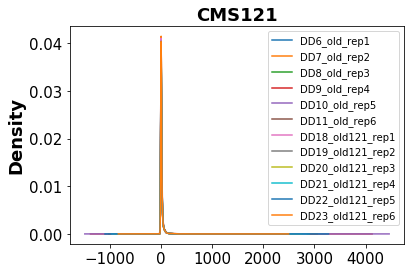

In [4]:
# Density

font1 = {
'weight' : 'bold',
'size'   : 18,
}
plt.figure(figsize=(20,15))
data.plot(kind = 'density', title = 'GSE101112_121')
plt.ylabel('Density',font1)
plt.title('CMS121',font1)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tick_params(labelsize=15)
plt.savefig("GSE121density.png",dpi=300,bbox_inches = 'tight')

In [5]:
#每个基因（行）wt样本的表达平均值(治疗)
cms121 = data.loc[:, 'DD18_old121_rep1' : 'DD23_old121_rep6'].mean(axis = 1)
cms121.head()

Annotation/Divergence
Fam175a     1.642667
1-Mar       6.848500
Mob3b       2.108667
Vapa       77.361667
Crat        9.476667
dtype: float64

In [6]:
#每个基因（行）的ko样本的表达平均值（对照）
ctrl = data.loc[:,'DD6_old_rep1':'DD11_old_rep6'].mean(axis = 1)
ctrl.head()

Annotation/Divergence
Fam175a     1.719000
1-Mar       6.026000
Mob3b       1.728667
Vapa       75.724833
Crat       10.838000
dtype: float64

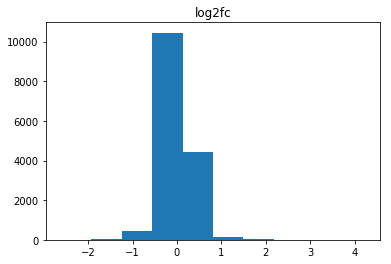

In [7]:
fold = cms121/ctrl
log2fc=-np.log2(fold)
#折叠变化的直方图
plt.hist(log2fc)
plt.title("log2fc")
plt.savefig("GSE121fold.png",dpi=300,bbox_inches = 'tight')

In [8]:
pvalue = []
for i in range(0, len(data)):
    ttest = stats.ttest_ind(data.iloc[i,6:12], data.iloc[i,0:6])
    pvalue.append(ttest[1])
pvalue[0:5]

[0.6912767703980381,
 0.004595669513467789,
 0.15380129298258083,
 0.6339270973230824,
 0.005814769475742696]

In [9]:
genearray = np.asarray(pvalue)
 
result = pd.DataFrame({'pvalue':genearray,'FoldChange':fold})
 
result['log(pvalue)'] = -np.log10(result['pvalue'])
result['log2FC'] = -np.log2(result['FoldChange'])
result['sig'] = 'normal'
 
result['size']  =np.abs(result['FoldChange'])/10
 
result.loc[(result.log2FC> 0.25 )&(result.pvalue < 0.05),'sig'] = 'up'
result.loc[(result.log2FC< -0.25 )&(result.pvalue < 0.05),'sig'] = 'down'
result.to_csv('GSE121_result.csv')

In [10]:
o=0
p=0
for i in result['sig']:
    if i=='up':
        o=o+1
    if i=='down':
        p=p+1
print(o)
print(p)

856
1017


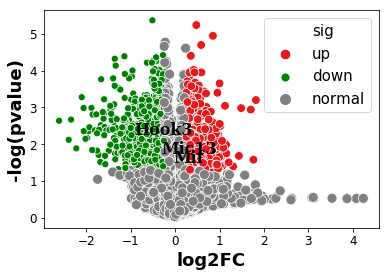

In [11]:
font2={
    'family':'serif',
    'weight':'bold',
      'size':16
}
ax = sns.scatterplot(x="log2FC", y="log(pvalue)",
                      hue='sig',
                      hue_order = ('up','down','normal'),
                      palette=("#E41A1C","green","grey"),
                     size='sig',sizes=(50, 100),
                      data=result)
ax.set_ylabel('-log(pvalue)',font1)                                    
ax.set_xlabel('log2FC',font1)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=15)
ax.tick_params(labelsize=15)
ax.text(result.loc['Hook3']['log2FC'], result.loc['Hook3']['log(pvalue)'], 'Hook3',ha='center', va='bottom', fontdict=font2)
ax.text(result.loc['Mif']['log2FC'], result.loc['Mif']['log(pvalue)'], 'Mif',ha='center', va='bottom', fontdict=font2)
ax.text(result.loc['2410015M20Rik']['log2FC'], result.loc['2410015M20Rik']['log(pvalue)'], 'Mic13',ha='center', va='bottom', fontdict=font2)
ax.tick_params(labelsize=12)
plt.savefig("GSE121fire.png",dpi=300,bbox_inches = 'tight')

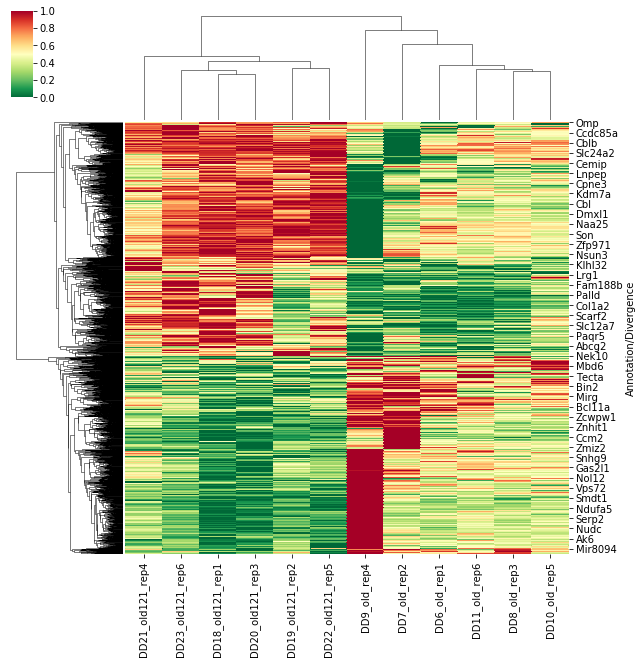

In [12]:
fold_cutoff = 0.25
pvalue_cutoff = 0.05
 
filtered_ids = []
for i in range(0, len(result)):
    if (abs(-np.log2(fold[i])) >= fold_cutoff) and (pvalue[i] <= pvalue_cutoff):
        filtered_ids.append(i)
        
filtered = data.iloc[filtered_ids,:]
filtered.to_csv('fi121GSE147.csv')
a=sns.clustermap(filtered, cmap='RdYlGn_r', standard_scale = 0)
plt.savefig("GSE121clus.png",dpi=300,bbox_inches = 'tight')